In [22]:
import cupy
import numpy
import math

Wait until conda gets 5.0 if you want RawKernel. Not fun to setup CUDA with libraries and build. All credit for original code codes to Jim Pivarski.

In [2]:
cupy.__version__

'5.0.0'

In [64]:
import numpy

def prepare(height, width):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32)
    return c, fractal

def run(c, fractal, maxiterations=20):
    fractal *= 0                  # set fractal to maxiterations without replacing it
    fractal += maxiterations
    z = c
    for i in range(maxiterations):
        z = z**2 + c
        diverge = z.real**2 + z.imag**2 > 2**2
        divnow = diverge & (fractal == maxiterations)
        fractal[divnow] = i
        z[diverge] = 2
    return fractal

In [65]:
c, fractal = prepare(800, 1200)

In [66]:
%%time
fractal = run(c, fractal)

CPU times: user 7.05 s, sys: 304 ms, total: 7.35 s
Wall time: 322 ms


In [67]:
c = cupy.array(c)
fractal = cupy.array(fractal)

In [68]:
%%time
fractal = run(c, fractal)

CPU times: user 31.2 ms, sys: 1.01 ms, total: 32.2 ms
Wall time: 31.7 ms


In [73]:
cupy_kernel = cupy.RawKernel("""
extern "C" 
__global__ void fractal(double* c, int* fractal, int height, int width, int maxiterations) {
    const int x = threadIdx.x + blockIdx.x*blockDim.x;
    const int y = threadIdx.y + blockIdx.y*blockDim.y;
    double creal = c[2 * (x + height*y)];
    double cimag = c[2 * (x + height*y) + 1];
    double zreal = creal;
    double zimag = cimag;
    fractal[x + height*y] = maxiterations;
    for (int i = 0;  i < maxiterations;  i++) {
        double zreal2 = zreal*zreal - zimag*zimag + creal;
        double zimag2 = 2*zreal*zimag + cimag;
        zreal = zreal2;
        zimag = zimag2;
        if (zreal*zreal + zimag*zimag > 4) {
            fractal[x + height*y] = i;
            break;
        }
    }
}
""", "fractal")

In [74]:
def run_pycuda(height, width, maxiterations=20):
    y, x = cupy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    grid = (int(math.ceil(height / 32)), int(math.ceil(width / 32)))
    c = x + y*1j
    fractal = cupy.empty(c.shape, dtype=cupy.int32) + maxiterations
    cupy_kernel(grid, (32,32,1),
                [c.view(cupy.double), fractal,
                cupy.int32(height),
                cupy.int32(width),
                cupy.int32(maxiterations)])
    return c, fractal

In [75]:
%%time
c, fractal = run_pycuda(800, 1200)    # Someone else is on my GPU

CPU times: user 3.62 ms, sys: 990 µs, total: 4.61 ms
Wall time: 4.07 ms


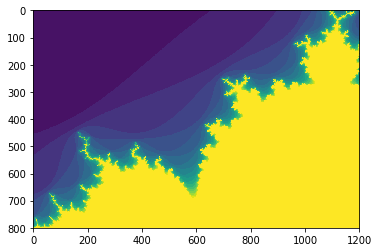

In [76]:
plt.imshow(fractal.get())